## Introducción a la explicabilidad e interpretabilidad en modelos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_3/notebooks/Nb_2b_Introduccion_explicabilidad_interpretabilidad.ipynb)

En este notebook encontrarás material introductorio para entender los conceptos de expicabilidad e interpretabilidad en modelos de inteligencia artificial.

Abordaremos el siguiente paso a paso:


*   Cargaremos el dataset load_wine y construiremos una red neuronal para resolver dicho problema.
*   Utilizaremos la técnica SHAP para explicar nuestro modelo.



In [9]:
#importamos las librerias necesarias a utilizar
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset

El [dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-dataset) cuenta con 178 registros, cada uno con 13 caracteristicas:

* Alcohol
* Malic Acid
* Ash
* Alcalinity of Ash
* Magnesium
* Total Phenols
* Flavanoids
* Nonflavanoid Phenols
* Proanthocyanins
* Colour Intensity
* Hue
* OD280/OD315 of diluted wines
* Proline

El dataset contiene 3 clases diferentes.

In [3]:
#Cargamos el conjunto de datos y procesamos
wine = load_wine()
X, y = wine.data, wine.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Dimension datos de entrenamiento: ", X_train.shape)
print("Dimension datos de prueba: ", X_test.shape)

Dimension datos de entrenamiento:  (124, 13)
Dimension datos de prueba:  (54, 13)


In [5]:
#Definimos la red neuronal a entrenar y compilamos el modelo
model = Sequential()

model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
#Entrenamos la red
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.4024 - loss: 1.0690 - val_accuracy: 0.4800 - val_loss: 0.9569
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5859 - loss: 0.9022 - val_accuracy: 0.7200 - val_loss: 0.8264
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5531 - loss: 0.9294 - val_accuracy: 0.6800 - val_loss: 0.7181
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6510 - loss: 0.7846 - val_accuracy: 0.8000 - val_loss: 0.6285
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7954 - loss: 0.6378 - val_accuracy: 0.8400 - val_loss: 0.5544
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8550 - loss: 0.5862 - val_accuracy: 0.8800 - val_loss: 0.4913
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8047 - loss: 0.5755 - val_accuracy: 0.9200 - val_loss: 0.4398
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9135 - loss: 0.4490 - val_accuracy: 0.9200 - val_loss: 0.3962
Epoch

In [8]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy en el conjunto de prueba: 1.0000


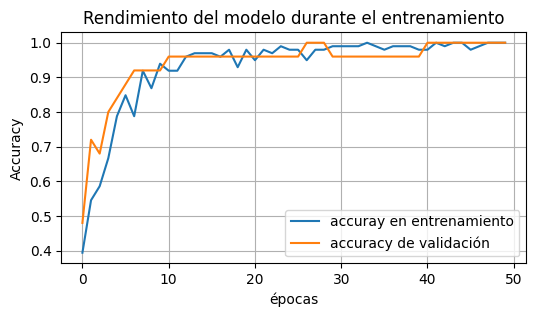

In [11]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='accuray en entrenamiento')
plt.plot(history.history['val_accuracy'], label='accuracy de validación')
plt.xlabel('épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Rendimiento del modelo durante el entrenamiento')
plt.grid()
plt.show()

* Ahora intentemos explicar/interpretar la red. Que caracteristicas son las que están aportando mas valor a la predicciones. Así, a primera vista, podemos ver que la red neural tiene un rendimiento perfecto, pero no sabemos que es lo que hace. Vamos a convertir esa caja negra el algo mas explicable.

In [16]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [17]:
#instalamos SHAP
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 18.0 MB/s eta 0:00:00


In [57]:
#Computemos los valores SHAP de nuestro modelo
import shap
explainer = shap.Explainer(model, X_train,feature_names=wine.feature_names)
shap_values = explainer(X_train)

PermutationExplainer explainer: 125it [00:11,  1.92it/s]


- Por ejemplo. Para nuestro modelo, la caracteristica que mas aporta para que se prediga de la clase 1, es **proline**, y  la que menos aporta es **malic_acid**.

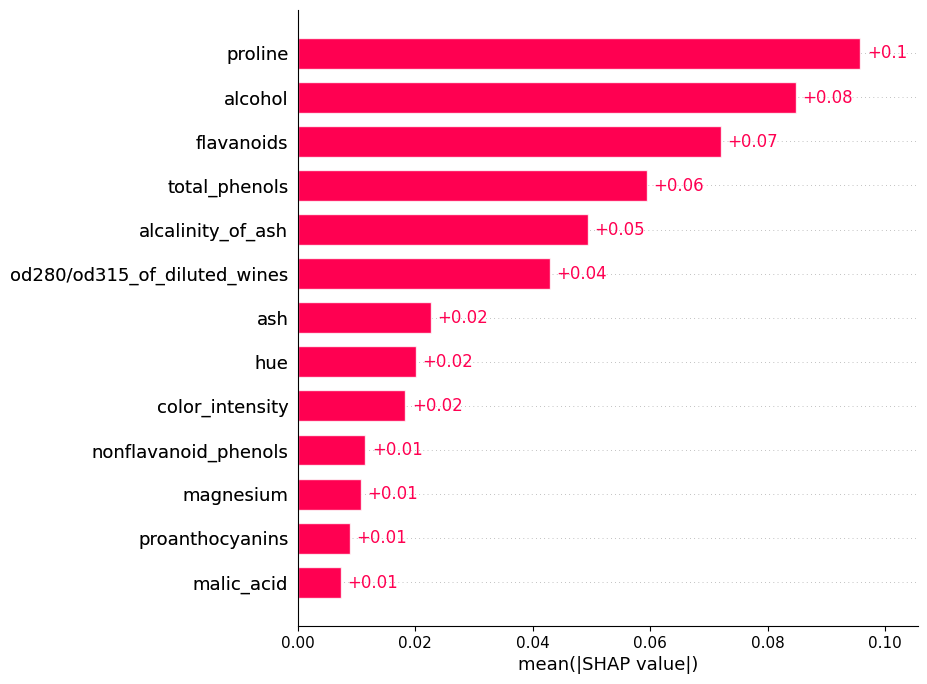

In [65]:
shap.plots.bar(shap_values[:,:,0], max_display=X_train.shape[1])

* Para la clase 2, la caracteristica que mas aporta es **alcohol** y la que menos aporta a dicha predicción es **nonflavanoid_phenols**.


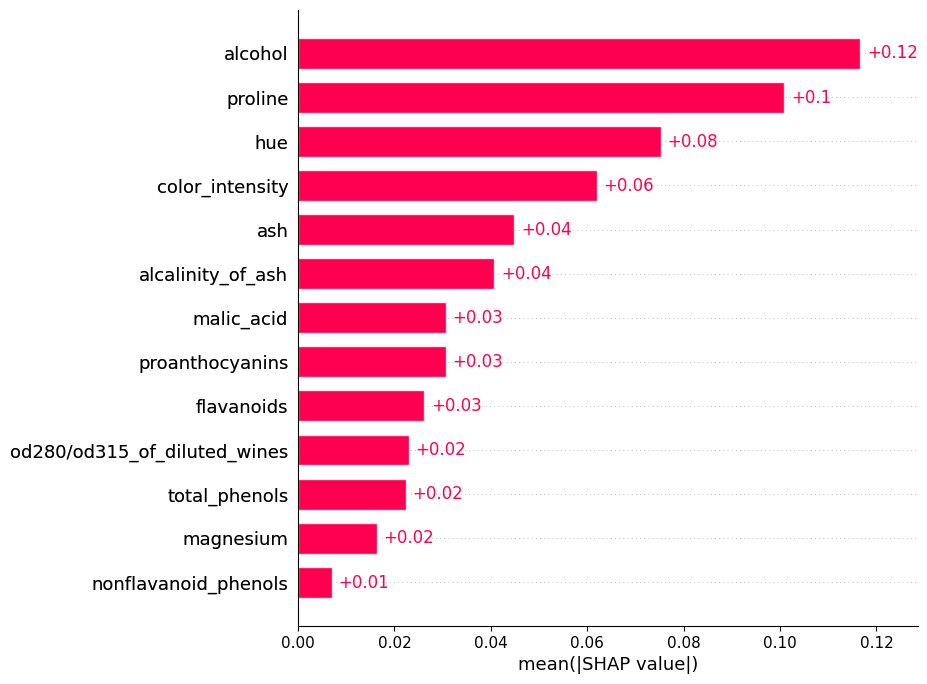

In [66]:
shap.plots.bar(shap_values[:,:,1], max_display=X_train.shape[1])

* Para la tercera clase, la caracteristica mas importante es **huge** y la menos importante es **magnesium**

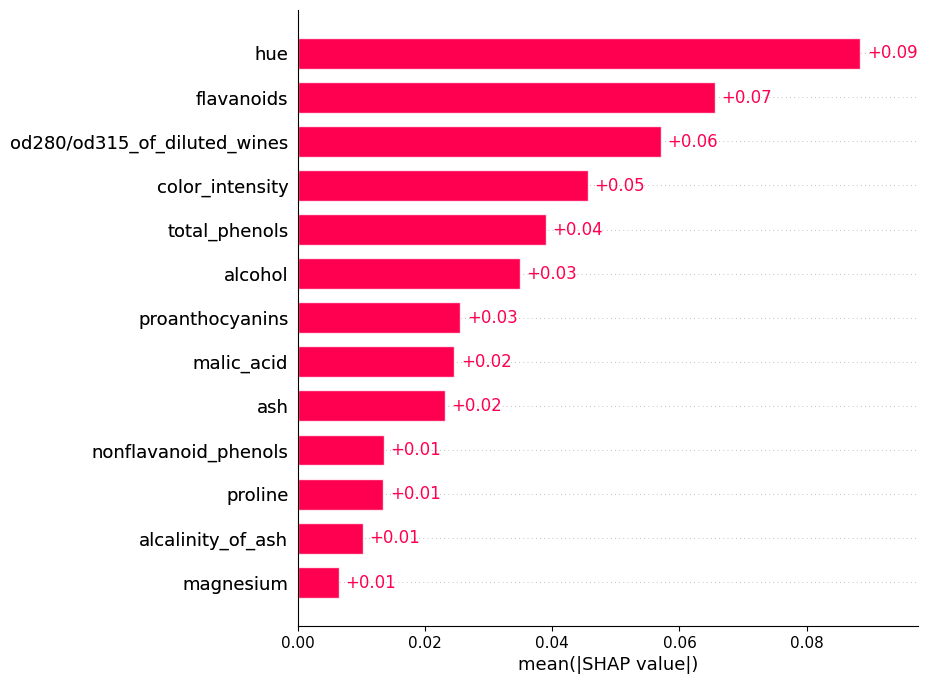

In [67]:
shap.plots.bar(shap_values[:,:,2], max_display=X_train.shape[1])

* Ahora tomemos un dato de entrenamiento y veamos como las caracteristicas influyeron para que la red se inclinara por la categoría cierta.

clase:  [0. 1. 0.]


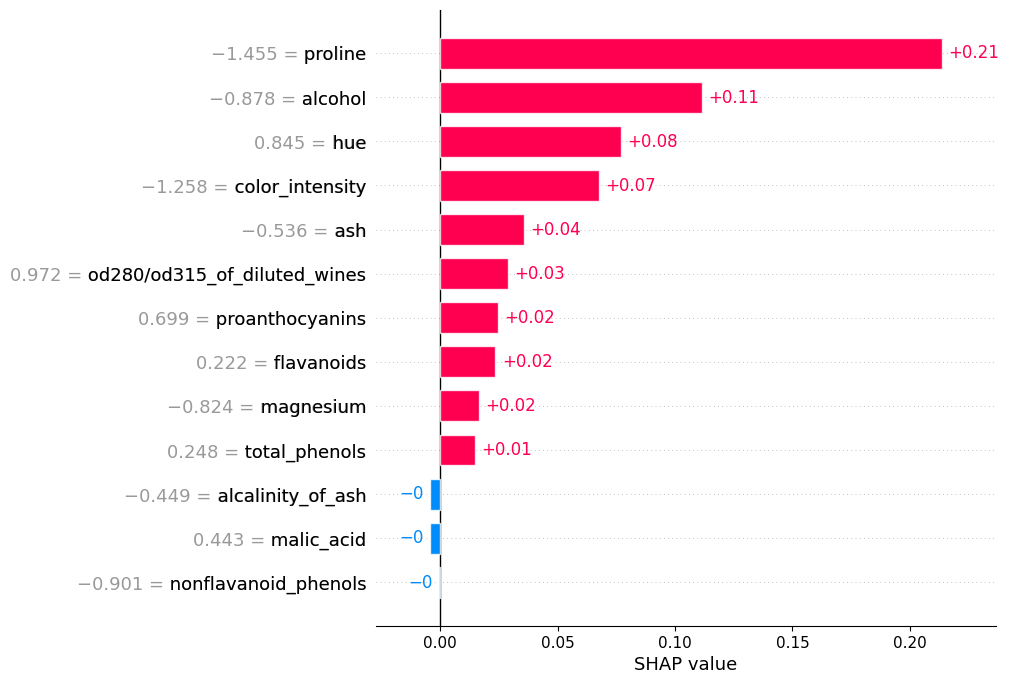

In [71]:
clase = y_train[4]
print("clase: ", clase)
shap.plots.bar(shap_values[4,:,np.argmax(clase)], max_display=X_train.shape[1])

* Del gráfico anterior podemos evidenciar que este ejemplo en contreto tuvo caracteristicas que no influyeron en la decision del modelo (**alcalinity_os_ash, malic_acid, nonflavanoid_phenols**). Por otro lado la caracteristica que mas influyó en este dato en particular fue **proline**.

* Tambien podriamos ver para cada clase como aporta cada caracteristica a la predicción del modelo.

clase 1


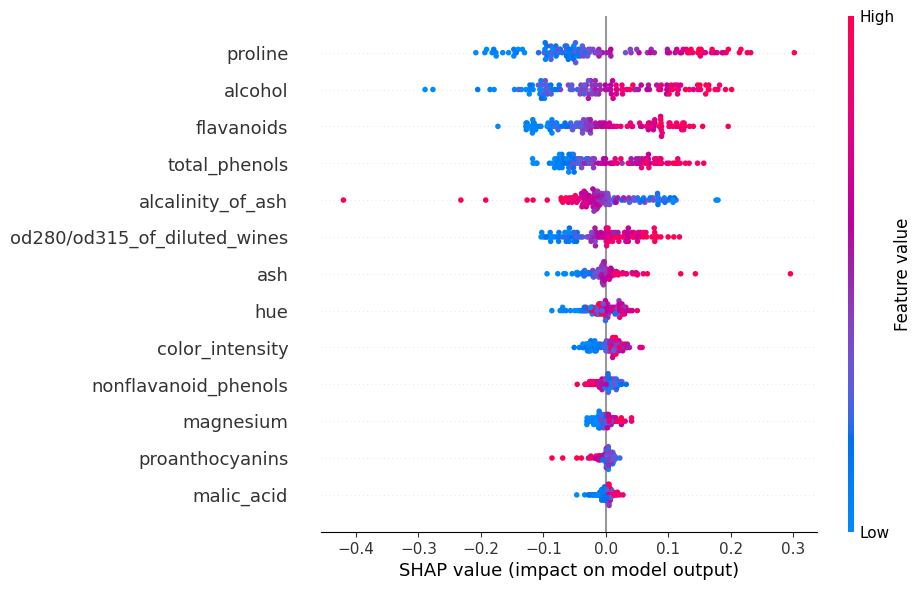

In [76]:
print("clase 1")
shap.plots.beeswarm(shap_values[:,:,0], max_display=X.shape[1])

clase 2


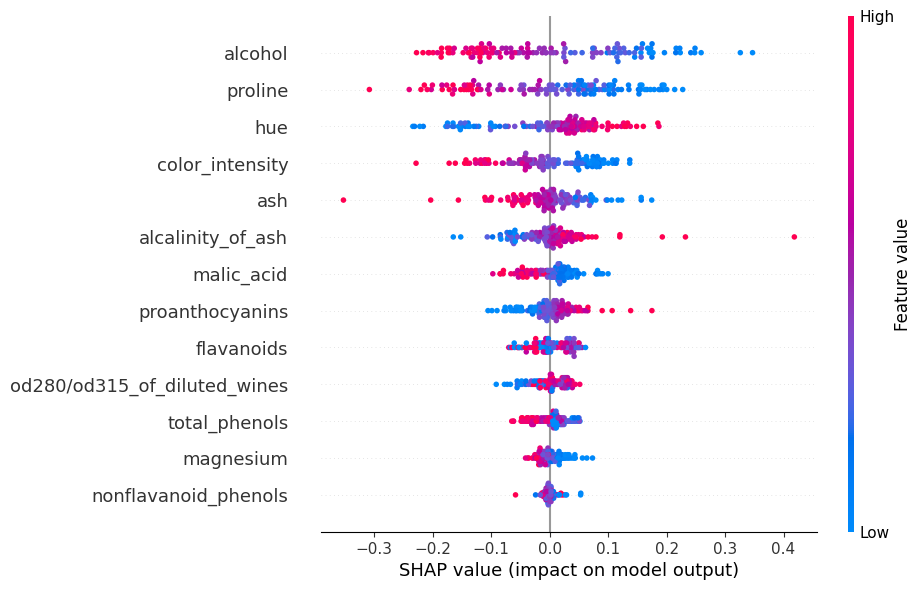

In [77]:
print("clase 2")
shap.plots.beeswarm(shap_values[:,:,1], max_display=X.shape[1])

clase 3


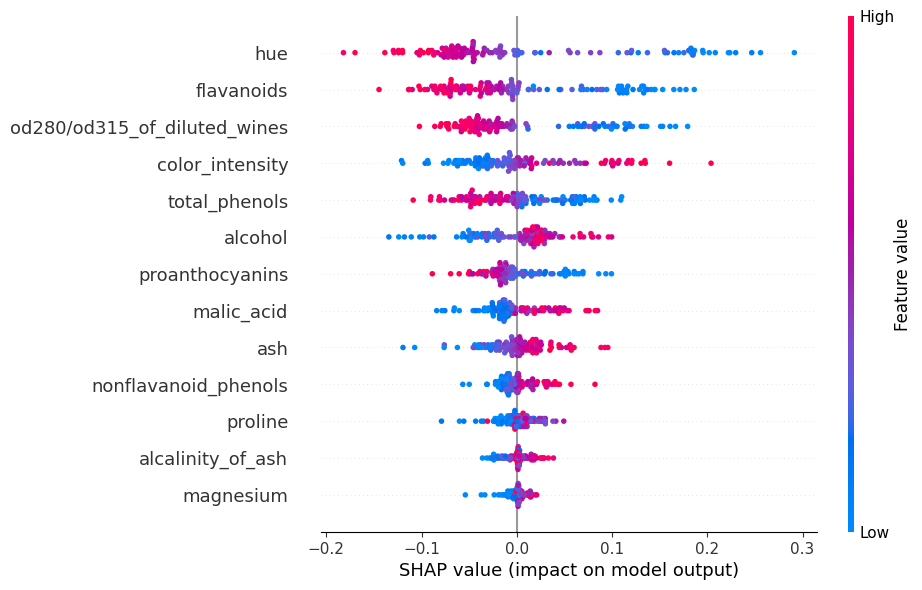

In [78]:
print("clase 3")
shap.plots.beeswarm(shap_values[:,:,2], max_display=X.shape[1])


## Conclusión:

*   Note que ahora podemos entender mucho mejor nuestra red, y que caracteristicas son mas importantes para determinar la clase a predecir. Por ejemplo, esto es muy útil para poder explicar nuestro modelo, para que una persona pueda entender cómo funciona. Por ejemplo, si fuese un conjunto de datos bancarios, saber por cuales caracteristicas fue rechazado un crédito y que así el cliente pueda mejorar.

